# Modeling True Positive and True Negative rates

We want to test the Bivariate Beta distribution built in the previous
sections. For that, we consider the following model: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ exposed to a disease individuals, and $Y_n$ denote the number of negative tests in $n_{neg}$ not exposed. The sensitivity $\gamma_s$ is the probability of positive test given the exposition, while the specificity $\gamma_e$ is the probability of a negative test given the non-exposition. Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3,
\alpha_4)$. With that, two different models can be assigned, with $\alpha$ being a constant vector or $\alpha_i \sim Gamma(a^i, b^i)$, where $a^i$ and $b^i$ are fixed.

In [1]:
import numpy as np
import pystan as ps

from scipy.stats import loggamma
import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

import pickle
from tqdm.notebook import tqdm

## Prior distributions 



In [5]:
compiled = True

In [4]:
if compiled: 
    sm = pickle.load(open('spec_sens_model.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'spec_sens_model.stan')
    with open('spec_sens_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Induced priors

In this model, we specify the priors on $\alpha$. However, the induced priors on the momments of $(X,Y)$ are complicated functions. For this, we generate samples from it. 

In [4]:
def prior_distributions(a, b, samples = 5000): 
    
    Z = [loggamma(c = a[i]).rvs(size = samples) for i in range(4)]
    alpha = [np.exp(Z[i])/b[i] for i in range(4)]
    
    X = np.random.beta(alpha[0] + alpha[1], alpha[2] + alpha[3])
    Y = np.random.beta(alpha[0] + alpha[2], alpha[1] + alpha[3])
    
    E_X, E_Y, Var_X, Var_Y, Cor_XY = moments_calculus(alpha)
    
    return (X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY)

#### Vague prior

We first use a vague prior $a_1 = a_2 = a_3 = a_4 = 1/100$ and $b_1 = b_2 = b_3 = b_4 = 1/100$. 

In [72]:
a = np.ones(4)*10
b = np.ones(4)*10

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

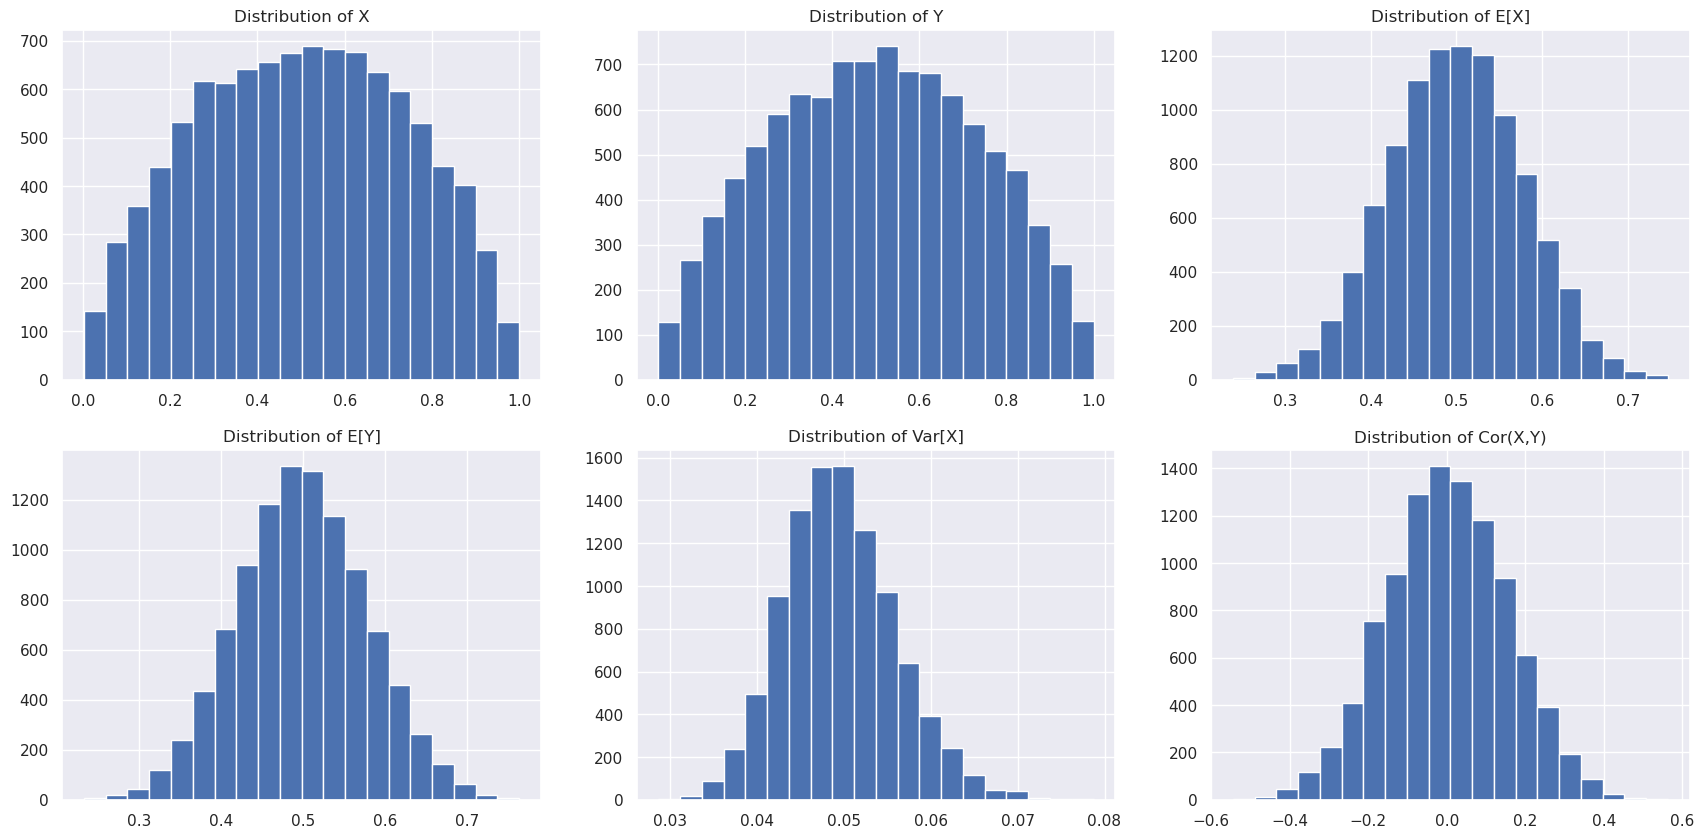

In [73]:
fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

More informative prior:$a_1 = a_2 = a_3 = a_4 = 1$ and $b_1 = b_2 = b_3 = b_4 = 1$.

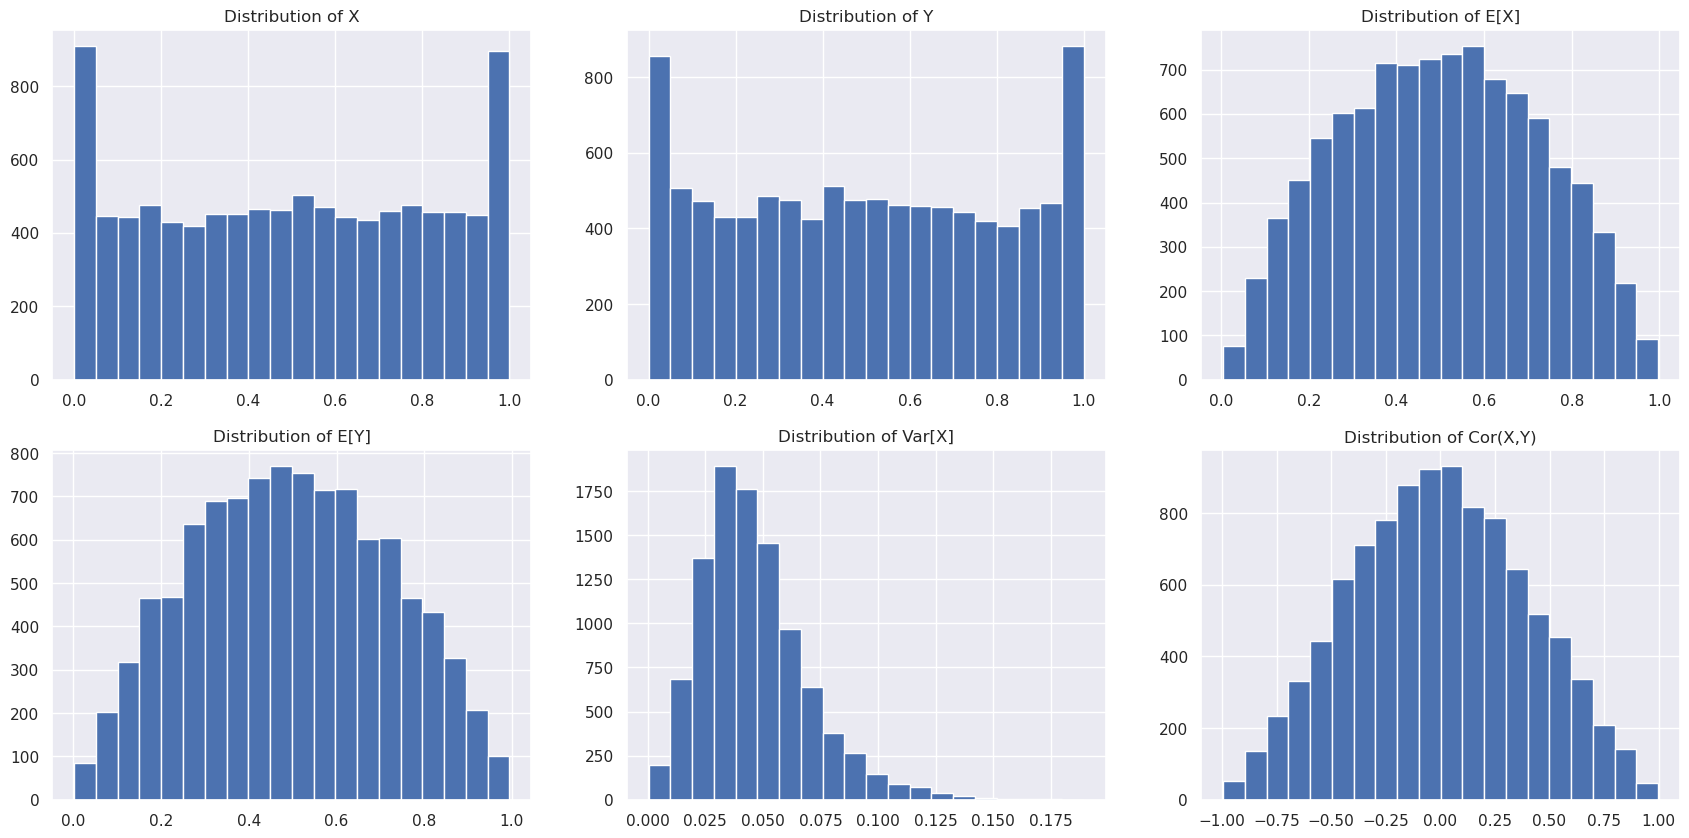

In [9]:
a = np.repeat(1, 4)
b = np.repeat(1, 4)

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

After compiling the model, we generate fake data to understand what happens. We will compare independent generated sensitivity and specificity from dependent. For the priors on $\alpha$, weak informative gamma distributions are placed. First, let's see the induced prior on the momments. 

TODO